### Import the relevant packages 

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

c:\Users\Robin\anaconda3\envs\MRI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading the tumor MRI images 

In [2]:
tumor = []
path_to_tumor_images = glob.iglob('./data/brain_tumor_dataset/yes/*.jpg')

for file in path_to_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (256, 256))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    tumor.append(img)


print(f'Number of tumor images: {len(tumor)}')

Number of tumor images: 154


### Reading the healthy MRI images

In [3]:
no_tumor = []
path_to_no_tumor_images = glob.iglob('./data/brain_tumor_dataset/no/*.jpg')

for file in path_to_no_tumor_images:
    img = cv2.imread(file)

    # resizing the image
    img = cv2.resize(img, (256, 256))

    # reordering the color channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])

    no_tumor.append(img)


print(f'Number of healthy images: {len(no_tumor)}')

Number of healthy images: 91


### Converting the lists of images to numpy arrays

In [4]:
tumor = np.array(tumor)
no_tumor = np.array(no_tumor)

### Taking a look at the dimensions of the arrays

In [5]:
print(f"Shape of tumor images array: {tumor.shape}")
print(f"Number of images: {tumor.shape[0]}")
print(f"Number of channels: {tumor.shape[3]} (RGB)")
print(f"Size of each channel: {tumor.shape[1]} x {tumor.shape[2]}")

print("\n")

print(f"Shape of no tumor images array: {no_tumor.shape}")
print(f"Number of images: {no_tumor.shape[0]}")
print(f"Number of channels: {no_tumor.shape[3]} (RGB)")
print(f"Size of each channel: {no_tumor.shape[1]} x {no_tumor.shape[2]}")

Shape of tumor images array: (154, 256, 256, 3)
Number of images: 154
Number of channels: 3 (RGB)
Size of each channel: 256 x 256


Shape of no tumor images array: (91, 256, 256, 3)
Number of images: 91
Number of channels: 3 (RGB)
Size of each channel: 256 x 256


### Visualize some of the MRI images 

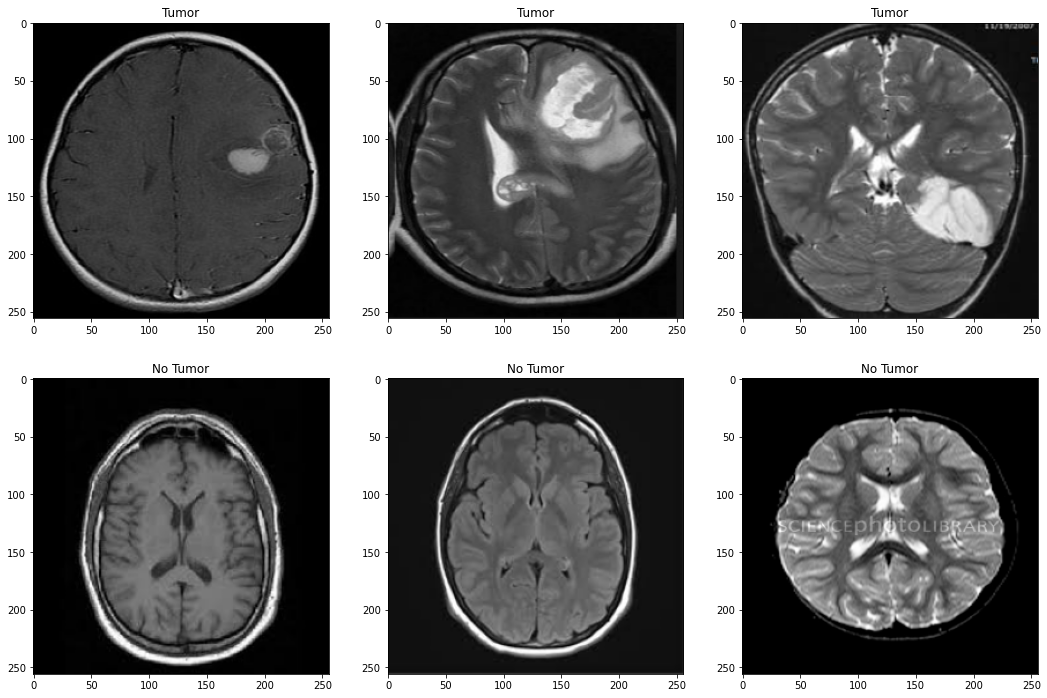

In [6]:
# initialize the plot
plt.figure(figsize=(18, 12))

for i in range(3):
    # tumor images
    plt.subplot(2, 3, i+1)
    plt.title('Tumor')
    plt.imshow(tumor[random.randint(0, len(tumor)-1)])

    # no_tumor images
    plt.subplot(2, 3, i+4)
    plt.title('No Tumor')
    plt.imshow(no_tumor[random.randint(0, len(no_tumor)-1)])

### Creating a custom pytorch Dataset class

In [7]:
class MRI(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        item = {"image": self.images[index], "label": self.labels[index]}
        return item

    def normalize(self):
        """Normalizes the images"""
        self.images = self.images / 255.0


In [8]:

# create arrays for the labels
tumor_labels = np.ones(tumor.shape[0])
no_tumor_labels = np.zeros(no_tumor.shape[0])

combined_images = np.concatenate((tumor, no_tumor), axis=0)
combined_labels = np.concatenate((tumor_labels, no_tumor_labels))

d = MRI(images=combined_images, labels=combined_labels)

d[0]["image"][100, 192, 2]

106